## Biomassi mudeldamine masinõppega
Selle skriptiga saad üles laadida oma CSV-failid ja nende põhjal luua Random Forest masinõppe mudeli. Skripti kasutamiseks mine hiirega esimesele kastile ja vajuta "Run" nuppu, et koodiplokk läbi jooksutada, tee sama ka järgmiste plokkidega. Kui midagi valesti läheb, saad lihtsa vaevaga uuesti algusest alustada.

### Andmete sisse lugemine ja ettevalmistamine

In [83]:
# laeme alla vajalikud paketid
import seaborn as sns
import numpy as np
import geopandas as gpd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from joblib import dump, load
from sklearn.metrics import r2_score
import shap
import matplotlib.pyplot as plt
import pandas as pd
import random
from sklearn.metrics import mean_squared_error

In [84]:
# loeme sisse kaugseire andmetega faili, fail on juba eelnevalt GitHubi laetud, eraldi seda laadima ei pea
fp = "data/biomass_2019_results.csv"
obs_data = pd.read_csv(fp)
# kontrollime andmestikku, vaadates esimest viit rida
obs_data.head(5)

,system:index,B1,B11,B12,B2,B3,B4,B5,B6,B7,B8,B8A,B9,BSI,ID,NDVI,VH,VV,VV/VH,.geo
0,0000000000000000004e_0,474.5,2727.5,1642.5,581.0,830.5,811.0,1360.0,2033.0,2246.0,2448.0,2531.5,2666.0,0.077579,ARU-A,0.502301,-23.260671,-14.653244,8.607427,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
1,00000000000000000071_0,481.5,2685.0,1566.5,558.0,792.0,752.5,1367.0,2160.5,2410.0,2610.0,2720.0,2685.0,0.040799,ARU-B,0.552416,-22.165546,-13.943181,8.222366,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
2,00000000000000000013_0,488.0,2683.0,1657.0,579.0,780.0,823.0,1332.0,2120.0,2354.0,2558.0,2681.0,2650.0,0.055547,ARU-C,0.513162,-22.229687,-14.168003,8.061683,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
3,0000000000000000003c_0,447.0,2415.5,1393.5,500.5,722.0,690.5,1303.5,2326.0,2616.0,2819.0,2925.5,2706.5,-0.033227,ARU-K,0.606497,-21.310101,-13.534452,7.775649,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
4,00000000000000000052_0,408.0,1756.5,887.5,387.0,621.0,427.0,1064.5,2611.0,3025.5,2841.0,3227.5,3387.5,-0.193015,ASV1-A-UUS,0.738678,-16.521025,-11.193062,5.327962,"{""geodesic"":false,""type"":""Point"",""coordinates""..."


In [85]:
# loeme sisse välitööde csv faili, fail on juba eelnevalt GitHubi laetud, eraldi seda laadima ei pea
fp = "data/fieldwork_data.csv"
fieldwork = pd.read_csv(fp)
# kontrollime andmestikku, vaadates esimest viit rida
fieldwork.head(5)

,ID,Aasta,Restoration,Subsite,Y,X,Graminoids_g_0.04m2,Graminoids_tha,Herbs_g_0.04m2,Herbs_tha,...,Fabaceae_tha,Moss_g_0.04m2,Moss_tha,Biomass_tha,Biomass_womoss_tha,Litter_g_0.04m2,Tree_cover_10m_radius,Shrub_cover_10m_radius,Herb_layer_height_1x1m_cm,Herb_cover_1x1m
0,ARU-A,2019,Restored,Open,58.881598,23.005726,3.972,0.99300,0.014,0.00350,...,0.00000,0.000,0.00000,0.99650,0.99650,0.986,0,5.0,10,65
1,ARU-B,2019,Restored,Overgrown,58.880597,23.006081,10.133,2.53325,3.223,0.80575,...,0.15350,0.180,0.04500,3.53750,3.49250,8.819,0,5.0,20,65
2,ARU-C,2019,Restored,Afforested,58.881313,23.006949,8.986,2.24650,3.075,0.76875,...,0.00000,0.022,0.00550,3.02075,3.01525,1.921,15,10.0,18,40
3,ARU-K,2019,Not_restored,Open,58.649971,23.314138,7.857,1.96425,1.791,0.44775,...,0.24100,0.027,0.00675,2.65975,2.65300,1.470,0,15.0,3,45
4,ASV1-A-UUS,2019,Restored,Open,58.648153,24.129923,11.128,2.78200,3.670,0.91750,...,0.39075,4.342,1.08550,5.17575,4.09025,4.236,20,40.0,20,90


In [86]:
# liidame kihid kokku uurimisala ID alusel
data = obs_data.merge(fieldwork, on="ID", how="left", suffixes=('', '_fw'))

In [87]:
# kontrollime, et kõik uurimisalad esineksid andmestikus ühe korra
if data["ID"].is_unique:
    print("Kõik ID-d on unikaalsed.")
else:
    print("Mõni ID esineb rohkem kui üks kord.")

Kõik ID-d on unikaalsed.


In [88]:
# puhastame andmestikku, jättes alles vaid vajalikud veerud
data = data[["B1", "B2", "B3", "B4", "B5", "B6", "B7", "B8", "B8A", "B9", "B11", "B12", "ID", "Biomass_tha", "Biomass_womoss_tha", "VH", "VV", "VV/VH", "BSI", "NDVI", "Restoration", "Subsite", "X", "Y", "Tree_cover_10m_radius", "Shrub_cover_10m_radius", "Herb_layer_height_1x1m_cm", "Herb_cover_1x1m"]]
data.columns

Index(['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11',
       'B12', 'ID', 'Biomass_tha', 'Biomass_womoss_tha', 'VH', 'VV', 'VV/VH',
       'BSI', 'NDVI', 'Restoration', 'Subsite', 'X', 'Y',
       'Tree_cover_10m_radius', 'Shrub_cover_10m_radius',
       'Herb_layer_height_1x1m_cm', 'Herb_cover_1x1m'],
      dtype='object')

In [89]:
# kontrollime, kuidas jagunevad uurimisala tüübid
data["Subsite"].value_counts()

Subsite
Open          37
Overgrown     36
Afforested    34
kontroll      24
Name: count, dtype: int64

In [90]:
# eraldame vaid numbrilised veerud korrelatsioonimaatriksi arvutamiseks
data_num = data.drop(["ID", "Subsite", "Restoration"], axis=1)
# kontrollime, et kõik veerud oleksid float või int
data_num.dtypes

B1                           float64
B2                           float64
B3                           float64
B4                           float64
B5                           float64
B6                           float64
B7                           float64
B8                           float64
B8A                          float64
B9                           float64
B11                          float64
B12                          float64
Biomass_tha                  float64
Biomass_womoss_tha           float64
VH                           float64
VV                           float64
VV/VH                        float64
BSI                          float64
NDVI                         float64
X                            float64
Y                            float64
Tree_cover_10m_radius          int64
Shrub_cover_10m_radius       float64
Herb_layer_height_1x1m_cm      int64
Herb_cover_1x1m                int64
dtype: object

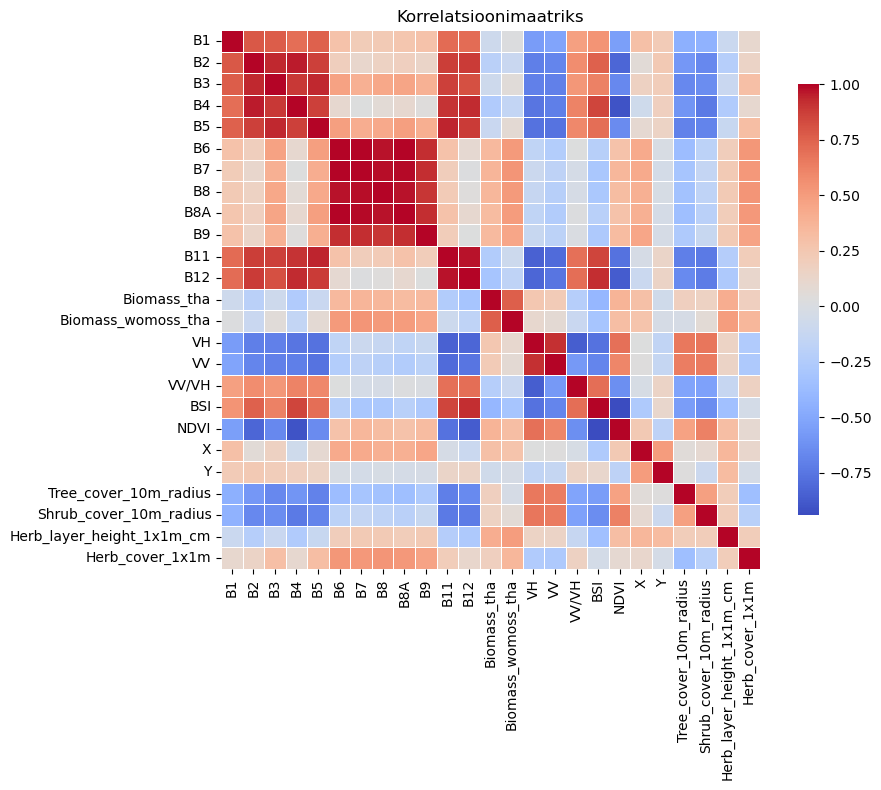

In [91]:
# kuvame korrelatsioonimaatriksi
correlation_matrix = data_num.corr()

plt.figure(figsize=(10, 8))

sns.heatmap(correlation_matrix, cmap='coolwarm', fmt='.2f', square=True, 
            cbar_kws={"shrink": .8}, linewidths=0.5)

plt.title('Korrelatsioonimaatriks')
plt.xticks(rotation=90)
plt.yticks(rotation=0)   

plt.tight_layout()
plt.show()

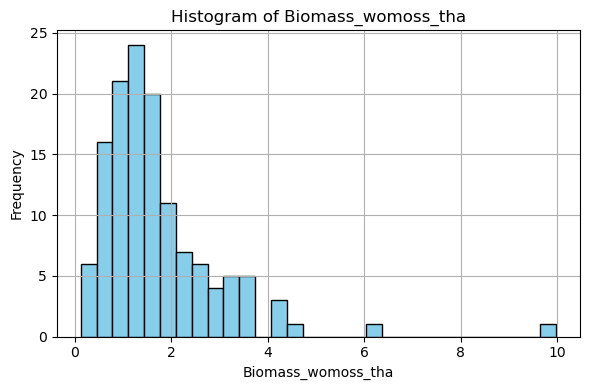

In [92]:
# loome uuritava väärtuse histogrammi
feature = 'Biomass_womoss_tha'

plt.figure(figsize=(6, 4))
data[feature].hist(bins=30, color='skyblue', edgecolor='black')
plt.title(f'Histogram of {feature}')
plt.xlabel(feature)
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [93]:
# eraldame andmestikust mitte-metsastunud uurimisalad. metsastunud uurimisaladel on väga vähe rohtset biomassi ning seda on satelliitidel puude alt raske tuvastada
cleaned = data[data["Subsite"] != "Afforested"]
# loeme allesjäänud uurimisalad kokku
len(cleaned)

97

### Masinõppe mudel
Järgnevalt jagame andmed treening- ja testimisandmeteks ning loome Random Forest regressiooni mudeli. Tavapäraselt jäetakse 70% andmetest mudeli treenimiseks ja 30% testimiseks. Võid proovida ka 80/20 jagamist.
Mudeldatavaks väärtuseks on rohtne biomass ehk Biomass_womoss_tha.

In [113]:
# eraldame mudeli sisendid (X) ja ennustatava väärtuse (Y)
# müra vältimiseks valime mudelisse vegetatsiooniga seotud kanalid
X = cleaned[["B6", "B8", "B12", "BSI", "VH", "NDVI"]]
y = cleaned["Biomass_womoss_tha"]

In [114]:
# jagame andmestiku treening-(70%) ja testandmeteks(30%)

test_size = 0.3
random_state = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = random_state)

len(X_train)

67

Järgmiseks otsime mudelile parimaid hüperparameetreid, proovime erinevaid kombinatsioone puude arvu (n_estimators), puu maksimaalse sügavuse (max_depth) ja lehe minimaalse vaatluste arvu (min_samples_leaf) vahel. Järjestame kombinatsioonid parima treening R2 alusel.

In [115]:
# otsime optimaalsemaid hüperparameetreid

results = []

for est in [50, 75, 100]:
    for depth in [3, 5, 7]:
        for leaf in [3, 5, 10]:
                rf = RandomForestRegressor(
                    n_estimators=est,
                    max_depth=depth,
                    min_samples_leaf=leaf,
                    max_features='sqrt',
                    random_state=random_state)
                rf.fit(X_train, y_train)
                train_r2 = r2_score(y_train, rf.predict(X_train))
                test_r2 = r2_score(y_test, rf.predict(X_test))
                
                results.append({
                    'n_estimators': est,
                    'max_depth': depth,
                    'min_samples_leaf': leaf,
                    'train_r2': train_r2,
                    'test_r2': test_r2})

results_df = pd.DataFrame(results)

results_df = results_df.sort_values(by='test_r2', ascending=False)

print(results_df.head(20))

    n_estimators  max_depth  min_samples_leaf  train_r2   test_r2
12            75          5                 3  0.577800  0.416649
21           100          5                 3  0.589027  0.416419
24           100          7                 3  0.595220  0.410398
15            75          7                 3  0.582364  0.406537
18           100          3                 3  0.555109  0.405730
9             75          3                 3  0.542683  0.403825
16            75          7                 5  0.460824  0.385107
10            75          3                 5  0.446243  0.384867
13            75          5                 5  0.460083  0.384272
19           100          3                 5  0.450255  0.376773
25           100          7                 5  0.464187  0.375973
22           100          5                 5  0.463637  0.375381
3             50          5                 3  0.566025  0.373867
6             50          7                 3  0.570556  0.371206
0         

**NB! Sisesta järgmisesse koodiplokki parimad hüperparameetrid eelmisest koodiplokist, 
nt 
n_estimators=50, 
max_depth=7, 
min_samples_leaf=3**

In [116]:
# sisesta parimad hüperparameetrid
regressor = RandomForestRegressor(
    n_estimators= SIIA PARIM n_estimators,
    max_depth= SIIA PARIM max_depth,
    min_samples_leaf= SIIA PARIM min_samples_leaf,
    max_features='sqrt',
    random_state=random_state)

# treenime mudeli
regressor.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, max_features='sqrt', min_samples_leaf=3,
                      random_state=42)

In [117]:
# arvutame treeningandmete R2
r2_training = regressor.score(X_train, y_train)
print(f"Treeningandmete R2: {r2_training:.2f}")

Treeningandmete R2: 0.59


In [118]:
# ennustame testimisandmetele
y_train_pred = regressor.predict(X_train)
y_test_pred = regressor.predict(X_test)

# arvutame testimisandmete R2
r2_testing = r2_score(y_test, y_test_pred)
print(f"Testimisandmete R2: {r2_testing:.2f}")

Testimisandmete R2: 0.42


In [119]:
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"Treeningandmete ruutkeskmine viga (RMSE): {rmse_train:.2f}")
print(f"Testimisandmete ruutkeskmine viga (RMSE): {rmse_test:.2f}")

Treeningandmete ruutkeskmine viga (RMSE): 0.87
Testimisandmete ruutkeskmine viga (RMSE): 0.97


## Mudeli analüüsimine ja tulemuste visualiseerimine
Järgmiseks arvutame mudeli SHAP väärtused. SHAP väärtused näitavad, kui palju iga tunnus panustab mudeli väljundisse. Sh näitavad need ka suunda, näiteks kõrge BSI (bare soil index) puhul on prognoositav biomassi mass väiksem, kõrge NDVI puhul aga suurem.

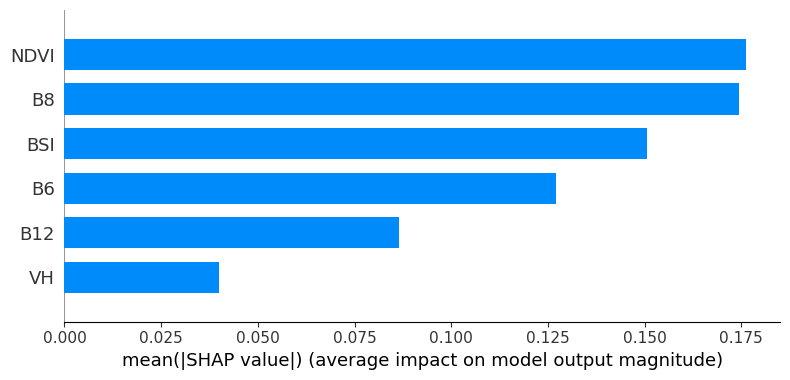

In [120]:
# arvutame SHAP väärtused mudeli paremaks mõistmiseks
explainer = shap.TreeExplainer(regressor)
shap_values = explainer.shap_values(X_train)

# visualiseerime SHAP väärtuseid
shap.summary_plot(shap_values=shap_values, features=X_train, feature_names=X_train.columns, plot_type="bar")

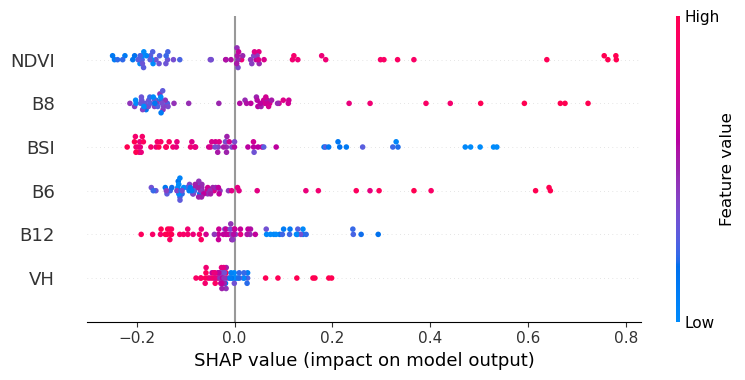

In [121]:
shap.summary_plot(shap_values=shap_values, features=X_train, feature_names=X_train.columns)

Viimaseks visualiseerime ennustatud vs tegelikke biomassi väärtuseid. Lisa joonise pealkirja oma nimi.

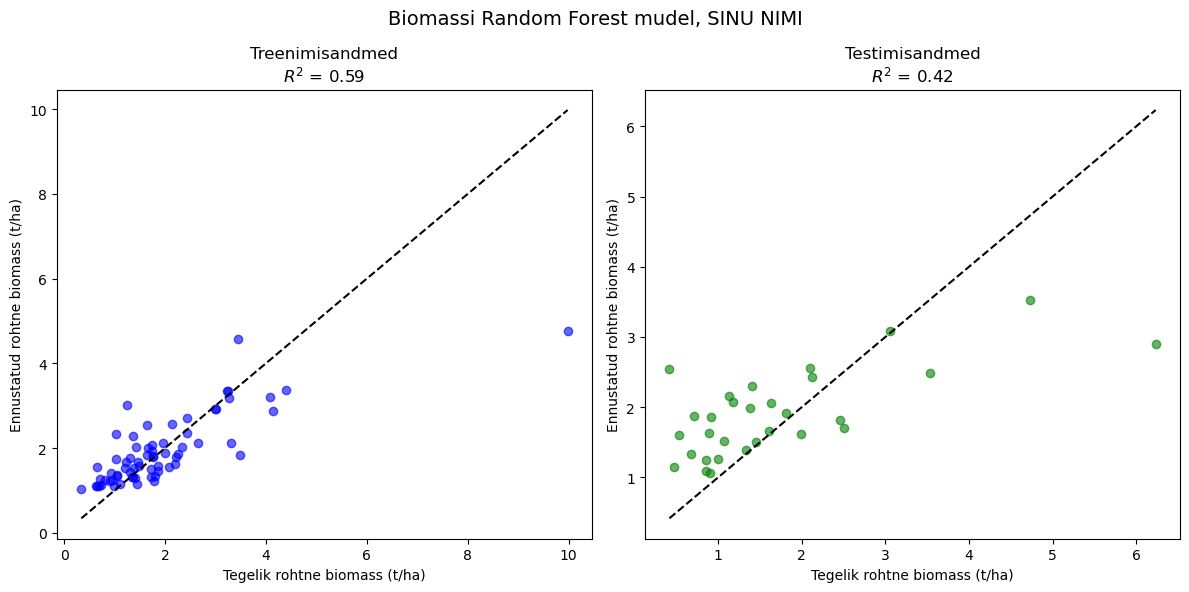

In [122]:
# visualiseerime masinõppe tulemusi
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].scatter(y_train, y_train_pred, color='blue', alpha=0.6)
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], '--k')
axes[0].set_xlabel('Tegelik rohtne biomass (t/ha)')
axes[0].set_ylabel('Ennustatud rohtne biomass (t/ha)')
axes[0].set_title(f'Treenimisandmed\n$R^2$ = {r2_training:.2f}')

axes[1].scatter(y_test, y_test_pred, color='green', alpha=0.6)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--k')
axes[1].set_xlabel('Tegelik rohtne biomass (t/ha)')
axes[1].set_ylabel('Ennustatud rohtne biomass (t/ha)')
axes[1].set_title(f'Testimisandmed\n$R^2$ = {r2_testing:.2f}')

# LISA joonise pealkirja oma nimi
fig.suptitle('Biomassi Random Forest mudel, SINU NIMI', fontsize=14)

plt.tight_layout()

# laeme joonise alla
fig.savefig('2019_biomass_model.png', dpi=300, bbox_inches='tight')
plt.show()


**Harjutuse lõpp – esita oma nimega joonis ülesande tulemusena.**